## Import modules and functions

In [1]:
# -*- coding: utf-8 -*-
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm

import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import glob
import re
import os

import pylab as pl
import matplotlib
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams
from scipy.signal import savgol_filter

from matplotlib.gridspec    import GridSpec
import import_ipynb

import Module_Diagnostics as MD
import numpy as np
from tempfile import mkdtemp
import os.path as path
import sys

from pathlib import Path
import json

#Debugger. For some reason, using it inside a function works well. Otherwise...
from IPython.core.debugger import set_trace
#exemple: 
# def debug():
#     set_trace()
    
#     `code_to_debug`
    
#     return

# debug()

importing Jupyter notebook from Module_Diagnostics.ipynb
testing compute_RMS(...):
This should be close to 1: 0.9732070092864397
This should be close to 0: 0.0


## Choose run

In [2]:
run_name = 'RUN_NAME'

### Only if working on lx-moissard
Cluster = 'Occ/'
run_name = '20_08_18_new_big_one_0'
filepath = '/data/Lathys/Visualisation/' + Cluster + run_name + '/ncfiles/'
filepath = '../ncfiles/'
filepath = '../' + Cluster + run_name + '/ncfiles/'

#This is used by the functions find_ip_shock(N, V) and find_mc_leading_edge(B)
metadata = {'t_shock_entrance' : 130,
            't_shock_exit'     : 240,
            't_MC_entrance'    : 130,
            't_MC_exit'        : 270}
#todo: autodefine t_collision? maybe from story_reader will be easier, as lines will cross on the multivariate plot

t_collision = None #default
t_collision = 216.5 #if known

from_time = 210
to_time = 235 #metadata['t_shock_exit']

#date = re.search('Magw_(.+?)_t', glob.glob(filepath+'Magw*_t'+ '%05d' % from_time +'.nc')[0]).group(1) 
date = "18_08_20"

print(f'date of the simulation (DD_MM_YY): {date}')

date of the simulation (DD_MM_YY): 18_08_20


In [3]:
storing_directory_json = filepath + "../shock_tracking/"
#The next line links directly to my PhD_Manuscript on Overleaf.com
#Saving plots there means that I do not need to worry about having the very last version before
#starting to write about it in Overleaf, since it will always be up to date.
dropbox = os.environ['DROPBOX']
dropbox_dir = storing_directory_json #dropbox + "/Apps/Overleaf/PhD_Manuscript/Images/LATHYS"

path_store_json = Path(storing_directory_json)

if not(path_store_json.exists()):
    os.system(f'mkdir {path_store_json}')

# name = "shock_tracking_" + run_name + ".json"
# name = "shock_tracking_occ.json"
name = "shock_tracking_bis_for_Article_Part_I_20_08_18_new_big_one_0.json"

path_json = Path(storing_directory_json + name)

In [4]:
with open(path_json, "r", encoding='utf-8') as shock_tracking:
            stored_data = json.load(shock_tracking)

In [5]:
stored_data.keys()

dict_keys(['00233', 'x', 'y', 'z', '00234', '00210', '00211', '00212', '00213', '00214', '00215', '00216', '00217', '00218', '00219', '00220', '00221', '00222', '00223', '00224', '00225', '00226', '00227', '00228', '00229', '00230', '00231', '00232'])

In [6]:
stored_data['00210'].keys()

dict_keys(['Vx', 'Vy', 'Vz'])

In [7]:
stored_data['00210']['Vx'].keys()

dict_keys(['(xy) plane', '(xz) plane'])

In [8]:
stored_data['00210']['Vx']['(xy) plane'].keys()

dict_keys(['y = -0.0', 'y = 90.0', 'y = 135.0', 'y = 180.0'])

## Def functions

In [9]:
x = np.array(stored_data['x'])
y = np.array(stored_data['y'])
z = np.array(stored_data['z'])

In [10]:
from scipy import signal
from collections.abc import Iterable

def simplified_find_ip_shock(V, test=None, first_point=False, verbose=False):
    
    Vx, Vy, Vz = tuple(V)    

    v_slice = np.sqrt( np.array(Vx)**2
                      +np.array(Vy)**2
                      +np.array(Vz)**2 ) 
    grad_v = np.gradient(v_slice)
    
    #Be careful, this test is very arbitrary. Works for the dataset I'm using.
    large_grad_v = [True if (grad_v[i] > 100*np.nanmean(grad_v)) else False for i in range(0,len(grad_v))]
    
    if not(test):
        test = large_grad_v
        
    if test:
        test = np.array(test) * np.array(large_grad_v)
                     
    ix_is = first_largest(grad_v, grad_v[test], verbose=verbose)   
    
    if np.isnan(ix_is):
        return np.nan
    
    x_is = x[ix_is]  

    if isinstance(x_is, Iterable):
        x_is = x_is[0]
        
#     if large_grad_v[ix_is-1]:
#         x_is = x_is+1./2 #todo:*dx    
#     if large_grad_v[ix_is+1]:
#         x_is = x_is-1./2 #todo:*dx   
      
    if verbose:
        print("grad_v[ix_is] = ", grad_v[ix_is])

    return x_is

def simplified_check_for_absurdities(list_pos, V, first_estimation=None, verbose=False, info=None):
   
    maximum_expected_change = 13
    minimum_expected_change = 2
    
    if info=='slow':
        maximum_expected_change = 8
    
    if first_estimation:
        prev_position = first_estimation
        maximum_expected_change = 20
        minimum_expected_change = 0
    else:
        prev_position = list_pos[-2]
        
    position = list_pos[-1]
    
    absurd = False
    test = np.ones(len(V))*True
    if ( abs(prev_position - position) > maximum_expected_change or 
         abs(position - prev_position) < minimum_expected_change or
         position > prev_position ) :
        absurd = True
        if verbose:
            print(f'''This is absurd, the ip shock was located at {prev_position} 
                      and now it would be at {position}!''')
        test = [True if (prev_position - maximum_expected_change 
                         <  x[i]  < 
                         prev_position - minimum_expected_change) else False for i in range(0, len(V[0]))]
    else:
        if verbose:
            print("Sounds like a good position for the ip shock")

    return {'absurd': absurd, 'test': test, 'prev_position': prev_position, 'position': position}


def first_largest(list1, sub_list1, verbose=False):
    '''
    This function extracts the three largest local maxima 
    from sub_list1.
    Then, it finds the one with the smallest x
    '''
    tmp = list(sub_list1.copy())
    three_largest = []
        
    try:
        three_largest.extend([tmp.pop(tmp.index(np.nanmax(tmp)))])
        c1 = x[np.where(list1 == three_largest[0])][0]
    except ValueError:
        return np.nan    
    if all(np.isnan(tmp)) or not(tmp):
        candidates = [c1]
       
    c2_ok = False
    if tmp and not(all(np.isnan(tmp))):
        three_largest.extend([tmp.pop(tmp.index(np.nanmax(tmp)))])
    #at this point, we have the two largest local maximas
        c2 = x[np.where(list1 == three_largest[1])][0]
        c2_ok = True
        
    if tmp and not(all(np.isnan(tmp))):
        three_largest.extend([tmp.pop(tmp.index(np.nanmax(tmp)))])
        #at this point, we have the three largest local maximas    
        c3 = x[np.where(list1 == three_largest[2])][0]
        candidates = [c1, c2, c3]
    elif c2_ok:
        candidates = [c1, c2]

    index_first = candidates.index(min(candidates))
    index_first = MD.aplatir(np.where(x == candidates[index_first]))
    #Which of the two candidate has the smallest x
    
    if verbose:
        print(f'the chosen candidate for the position of the ip shock is {x[index_first]}')
    
    return index_first

## Trace Shock

### All figures

In [11]:
verbose = False
rcParams["figure.figsize"] = [17, 8]

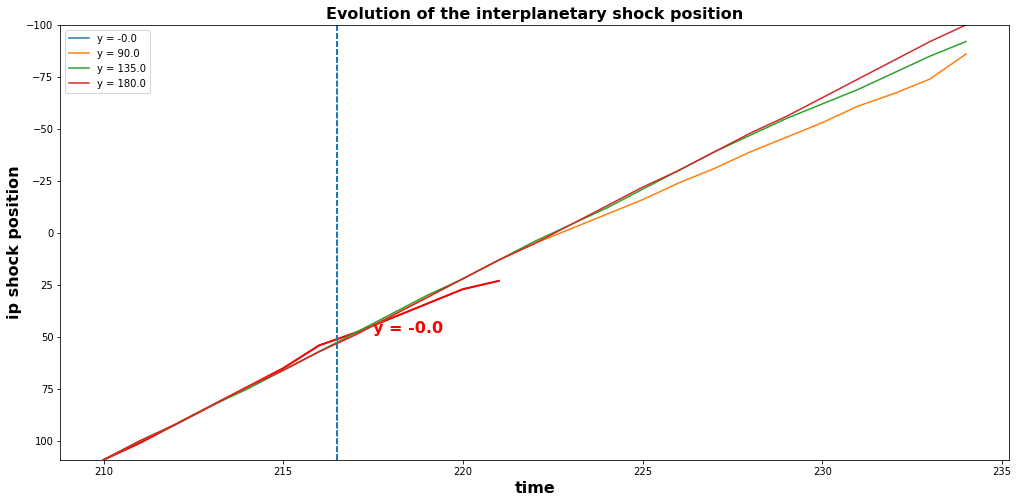

In [12]:
for y_slice in stored_data['00210']['Vx']['(xy) plane'].keys():

  
    t = []
    pos = []

    for time in sorted(stored_data):

        if verbose:
            print(f'time = {time}')

        if not(time.isnumeric()) or int(time)>=235:
            continue
  
            
        Vx_xy = stored_data[time]['Vx']['(xy) plane']
        Vy_xy = stored_data[time]['Vy']['(xy) plane']
        Vz_xy = stored_data[time]['Vz']['(xy) plane']

        if time=='00210':
            first_estimation = 115
        else:
            first_estimation = None
        if (y_slice == 'y = -0.0') and (int(time) > 216):
            info = 'slow'
        else:
            info = None

        Vx = Vx_xy[y_slice]
        Vy = Vy_xy[y_slice]
        Vz = Vz_xy[y_slice]
        
        V = (Vx, Vy, Vz)

        x_is =  simplified_find_ip_shock(V)
        t.extend([int(time)])
        pos.extend([x_is])

        if verbose:
            print(f'first try x_is = {x_is}')    

        absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose, info=info)
        j = 0
        while absurdity['absurd']:
            test = absurdity['test']
            x_is =  simplified_find_ip_shock(V, test=test, verbose=verbose)
            pos[-1] = x_is
            absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose, info=info)
            j = j+1
            if j==6:
                pos[-1]=np.nan
                break

        if (pos[-1]==-100 or np.isnan(pos[-1])):
            break

                    
    if y_slice == 'y = -0.0':
        t_fig_y0 = t[:-2]
        pos_fig_y0 = pos[:-2]
    if y_slice == 'y = 90.0':
        t_fig_y = t[:-1]
        pos_fig_y = pos[:-1]
    if y_slice == 'y = 180.0':
        t_ref = t[:-1]
        pos_ref = pos[:-1]
        
        
    plt.plot(t, pos, label=y_slice)
    plt.title(f'Evolution of the interplanetary shock position', weight='bold', fontsize='16')
    plt.ylim([max(pos), min(pos)])
    plt.ylabel('ip shock position', weight='bold', fontsize='16')
    plt.xlabel('time', weight='bold', fontsize='16')
    plt.axvline(216.5, linestyle='--', )
    
    if y_slice == 'y = -0.0':
        plt.plot(t, pos, color='red', linewidth=2) 
        plt.text(217.5,48, y_slice, color='red', weight='bold', fontsize='16')
        
plt.legend()
saving_title = "shock_tracking_xy"
plt.savefig(dropbox_dir + '/' + saving_title + run_name + ".png",
            transparent=True, bbox_inches='tight', pad_inches=0.1)
plt.show()

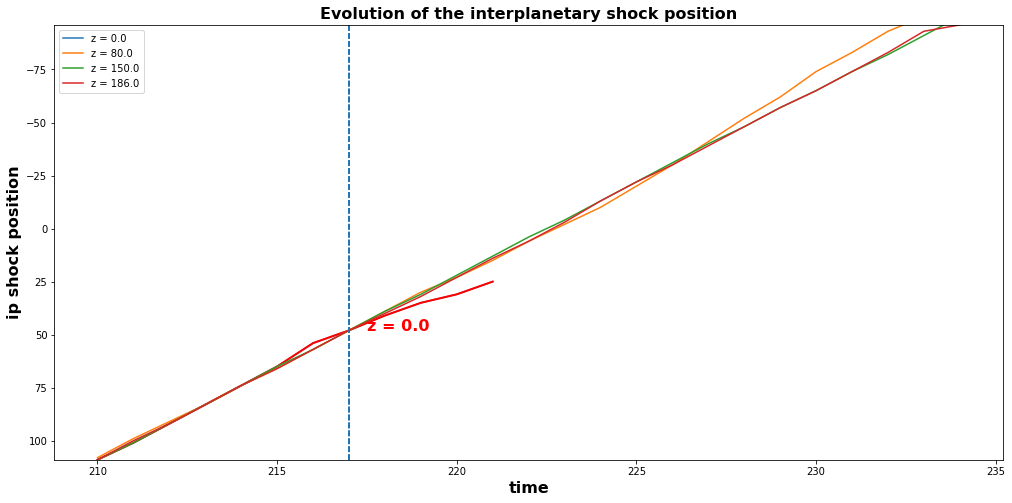

In [13]:
for z_slice in stored_data['00210']['Vx']['(xz) plane'].keys():

    if z_slice == 'z = -0.0':
        continue
        # plt.plot(t, pos, color='red', linewidth=2) 
        # plt.text(217.5,48, y_slice, color='red', weight='bold', fontsize='16')
 
    if verbose:
        print(z_slice)

    t = []
    pos = []

    for time in sorted(stored_data):

        if verbose:
            print(f'time = {time}')

        if not(time.isnumeric()):
            continue
            
        Vx_xz = stored_data[time]['Vx']['(xz) plane']
        Vy_xz = stored_data[time]['Vy']['(xz) plane']
        Vz_xz = stored_data[time]['Vz']['(xz) plane']

        if time=='00210':
            first_estimation = 115
        else:
            first_estimation = None
        if (z_slice == 'z = 0.0') and (int(time) > 216):
            info = 'slow'
        else:
            info = None

        Vx = Vx_xz[z_slice]
        Vy = Vy_xz[z_slice]
        Vz = Vz_xz[z_slice]
        
        V = (Vx, Vy, Vz)

        x_is =  simplified_find_ip_shock(V)
        t.extend([int(time)])
        pos.extend([x_is])

        if verbose:
            print(f'first try x_is = {x_is}')    

        absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose, info)
        j = 0
        while absurdity['absurd']:
            test = absurdity['test']
            x_is =  simplified_find_ip_shock(V, test=test, verbose=verbose)
            pos[-1] = x_is
            absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose, info)
            j = j+1
            if j==6:
                pos[-1]=np.nan
                break
 
        if (pos[-1]==-100 or np.isnan(pos[-1])):
            break


    if z_slice == 'z = 80.0':
        t_fig_z = t[:-1]
        pos_fig_z = pos[:-1]


    plt.plot(t, pos, label=z_slice)
    plt.title(f'Evolution of the interplanetary shock position', weight='bold', fontsize='16')
    plt.ylim([max(pos), min(pos)])
    plt.ylabel('ip shock position', weight='bold', fontsize='16')
    plt.xlabel('time', weight='bold', fontsize='16')
    plt.axvline(217, linestyle='--', )

    if z_slice == 'z = 0.0':
        plt.plot(t, pos, color='red', linewidth=2) 
        plt.text(217.5,48, z_slice, color='red', weight='bold', fontsize='16')
        
plt.legend()
saving_title = "shock_tracking_xz"
plt.savefig(dropbox_dir + '/' + saving_title + run_name + ".png",
            transparent=True, bbox_inches='tight', pad_inches=0.1)
plt.show()

### Figures for publication

#### Ugly manual fixes at last minute

In [22]:
# fix weird detection due to IP shoc / bow shock being too close to each other
if t_collision:
    for i in range(0,len(t_fig_y0)):
        if t_fig_y0[i] < t_collision:
            pos_fig_y0[i] = pos_ref[i]
        if pos_fig_y0[i] < pos_ref[i]:
            pos_fig_y0[i] = pos_ref[i]+1

#### Figures

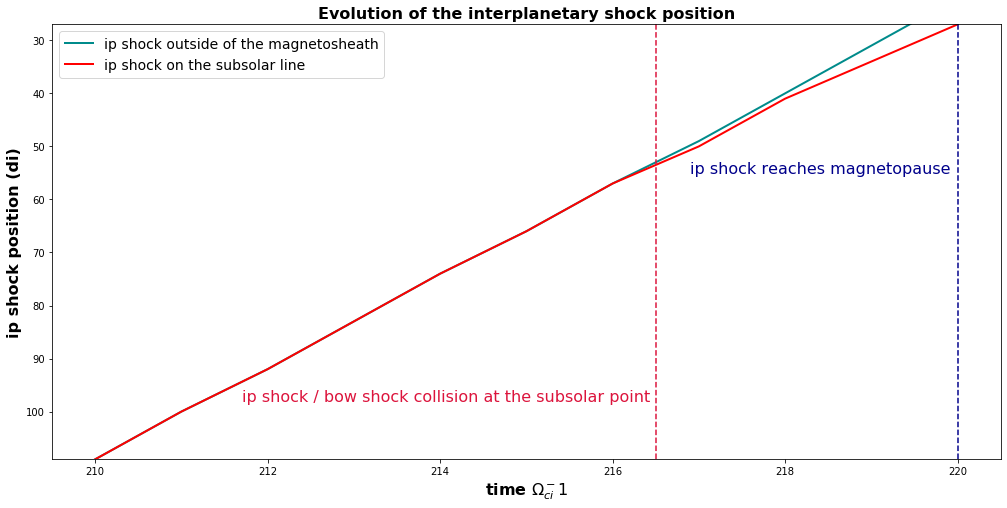

In [23]:
'''''''''''''''''''''''
Figure for publication
'''''''''''''''''''''''

rcParams["figure.figsize"] = [17, 8]


    
plt.plot(t_fig_y0 , pos_ref[0:len(t_fig_y0)]    , label='ip shock outside of the magnetosheath'
         , color = "darkcyan", linewidth=2.0)
plt.plot(t_fig_y0 , pos_fig_y0 , label='ip shock on the subsolar line', linewidth=2.0, color='red')
plt.title(f'Evolution of the interplanetary shock position', weight='bold', fontsize='16')
plt.ylim([max(pos_fig_y0), min(pos_fig_y0)])
plt.ylabel('ip shock position (di)', weight='bold', fontsize='16')
plt.xlabel(r'time $\Omega_{ci}^-1$', weight='bold', fontsize='16')
plt.axvline(216.5, linestyle='--', color='crimson')
plt.text(211.7,98, 'ip shock / bow shock collision at the subsolar point', color='crimson', fontsize=16)
plt.axvline(220, linestyle='--', color='darkblue')
plt.text(216.90,55, 'ip shock reaches magnetopause', color='darkblue', fontsize=16)
plt.legend(fontsize=14)
saving_title = "shock_tracking_pretty_bs_to_mp"
plt.savefig(dropbox_dir + '/' + saving_title + run_name + ".png",
            transparent=True, bbox_inches='tight', pad_inches=0.1)
plt.show()

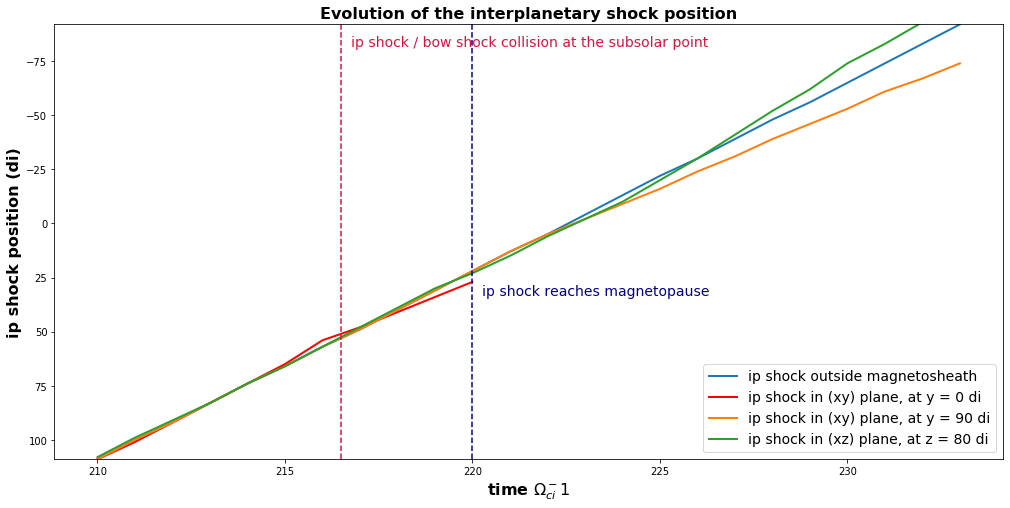

In [16]:
'''''''''''''''''''''''
Figure for publication
'''''''''''''''''''''''

plt.plot(t_ref    , pos_ref    , label='ip shock outside magnetosheath', linewidth=2.0)
plt.plot(t_fig_y0 , pos_fig_y0 , label='ip shock in (xy) plane, at y = 0 di', linewidth=2.0, color='red')
plt.plot(t_fig_y  , pos_fig_y  , label='ip shock in (xy) plane, at y = 90 di', linewidth=2.0)
plt.plot(t_fig_z  , pos_fig_z  , label='ip shock in (xz) plane, at z = 80 di', linewidth=2.0)
plt.title(f'Evolution of the interplanetary shock position', weight='bold', fontsize='16')
plt.ylim([max(pos_ref), min(pos_ref)])
plt.ylabel('ip shock position (di)', weight='bold', fontsize='16')
plt.xlabel(r'time $\Omega_{ci}^-1$', weight='bold', fontsize='16')
plt.axvline(216.5, linestyle='--', color='crimson')
plt.text(216.75,-82, 'ip shock / bow shock collision at the subsolar point', color='crimson', fontsize=14)
plt.axvline(220, linestyle='--', color='darkblue')
plt.text(220.25,33, 'ip shock reaches magnetopause', color='darkblue', fontsize=14)
plt.legend(fontsize=14)
saving_title = "shock_tracking_pretty"
plt.savefig(dropbox_dir + '/' + saving_title + run_name + ".png",
            transparent=True, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [17]:
pos_ref[0:len(t_fig_y0)], pos_fig_y0

([109.0, 100.0, 92.0, 83.0, 74.0, 66.0, 57.0, 49.0, 40.0, 31.0, 22.0],
 [109.0, 101.0, 92.0, 83.0, 74.0, 65.0, 54.0, 48.0, 41.0, 34.0, 27.0])

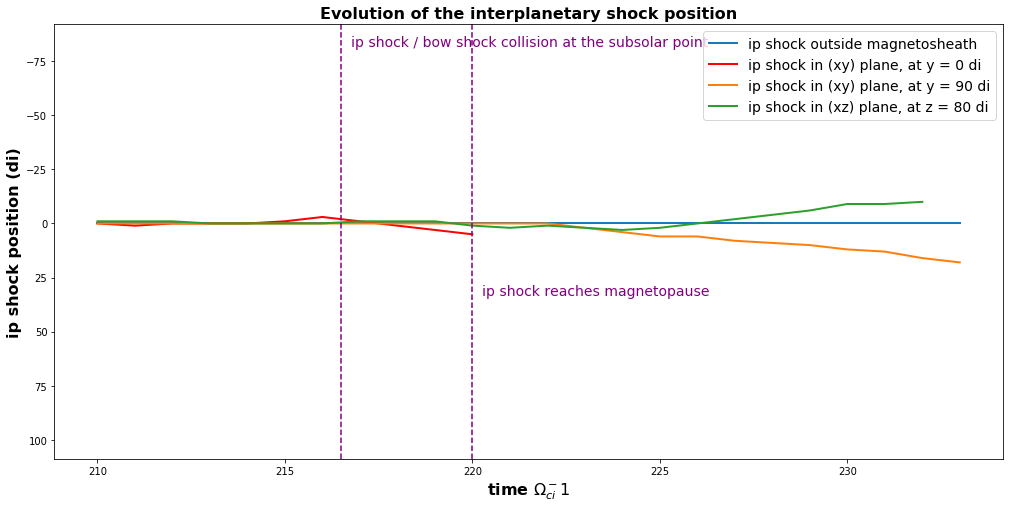

In [18]:
plt.plot(t_ref    , 0*np.array(t_ref)    , label='ip shock outside magnetosheath', linewidth=2.0)
plt.plot(t_fig_y0 , np.array(pos_fig_y0) - np.array(pos_ref)[0:len(pos_fig_y0)] , label='ip shock in (xy) plane, at y = 0 di', linewidth=2.0, color='red')
plt.plot(t_fig_y  , np.array(pos_fig_y)  - np.array(pos_ref), label='ip shock in (xy) plane, at y = 90 di', linewidth=2.0)
plt.plot(t_fig_z  , np.array(pos_fig_z)  - np.array(pos_ref)[0:len(pos_fig_z)], label='ip shock in (xz) plane, at z = 80 di', linewidth=2.0)
plt.title(f'Evolution of the interplanetary shock position', weight='bold', fontsize='16')
plt.ylim([max(pos_ref), min(pos_ref)])
plt.ylabel('ip shock position (di)', weight='bold', fontsize='16')
plt.xlabel(r'time $\Omega_{ci}^-1$', weight='bold', fontsize='16')
plt.axvline(216.5, linestyle='--', color='purple')
plt.text(216.75,-82, 'ip shock / bow shock collision at the subsolar point', color='purple', fontsize=14)
plt.axvline(220, linestyle='--', color='purple')
plt.text(220.25,33, 'ip shock reaches magnetopause', color='purple', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Test 

time = 00210
the chosen candidate for the position of the ip shock is -30.0
grad_v[ix_is] =  158.1868194227047
first try x_is = -30.0
This is absurd, the ip shock was located at 115 
                      and now it would be at -30.0!
[ 96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109.
 110. 111. 112. 113. 114.]
the chosen candidate for the position of the ip shock is 109.0
grad_v[ix_is] =  125.10457558597483
Sounds like a good position for the ip shock


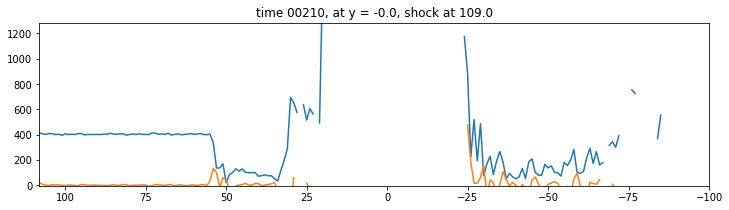

time = 00211
the chosen candidate for the position of the ip shock is -28.0
grad_v[ix_is] =  177.5344423334862
first try x_is = -28.0
This is absurd, the ip shock was located at 109.0 
                      and now it would be at -28.0!
[ 97.  98.  99. 100. 101. 102. 103. 104. 105. 106.]
the chosen candidate for the position of the ip shock is 101.0
grad_v[ix_is] =  137.93447252419833
Sounds like a good position for the ip shock


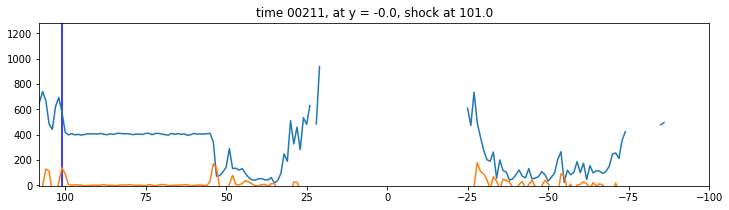

time = 00212
the chosen candidate for the position of the ip shock is -28.0
grad_v[ix_is] =  198.38997033816497
first try x_is = -28.0
This is absurd, the ip shock was located at 101.0 
                      and now it would be at -28.0!
[89. 90. 91. 92. 93. 94. 95. 96. 97. 98.]
the chosen candidate for the position of the ip shock is 92.0
grad_v[ix_is] =  132.34608822122055
Sounds like a good position for the ip shock


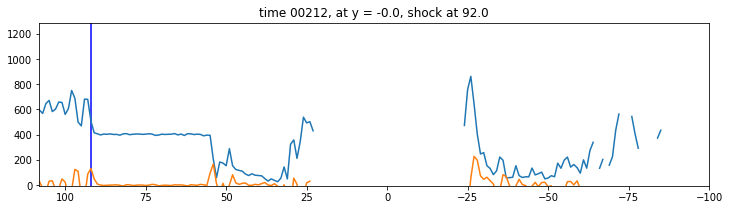

time = 00213
the chosen candidate for the position of the ip shock is -26.0
grad_v[ix_is] =  338.40979782558105
first try x_is = -26.0
This is absurd, the ip shock was located at 92.0 
                      and now it would be at -26.0!
[80. 81. 82. 83. 84. 85. 86. 87. 88. 89.]
the chosen candidate for the position of the ip shock is 83.0
grad_v[ix_is] =  144.15714034952939
Sounds like a good position for the ip shock


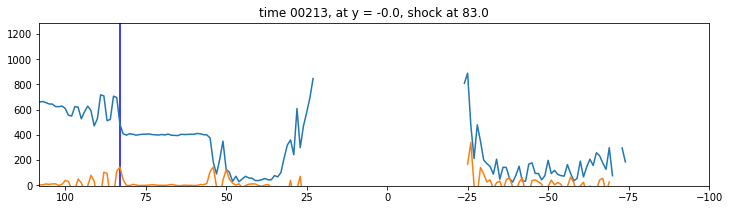

time = 00214
the chosen candidate for the position of the ip shock is -25.0
grad_v[ix_is] =  264.5566782847293
first try x_is = -25.0
This is absurd, the ip shock was located at 83.0 
                      and now it would be at -25.0!
[71. 72. 73. 74. 75. 76. 77. 78. 79. 80.]
the chosen candidate for the position of the ip shock is 74.0
grad_v[ix_is] =  143.57428383060605
Sounds like a good position for the ip shock


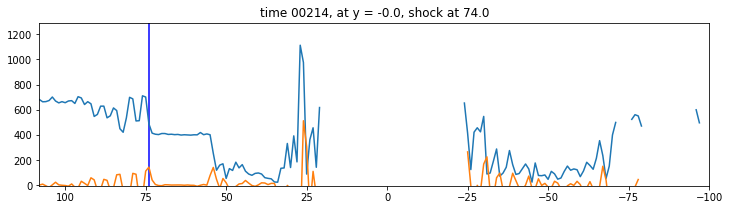

time = 00215
the chosen candidate for the position of the ip shock is -25.0
grad_v[ix_is] =  306.9312522220971
first try x_is = -25.0
This is absurd, the ip shock was located at 74.0 
                      and now it would be at -25.0!
[62. 63. 64. 65. 66. 67. 68. 69. 70. 71.]
the chosen candidate for the position of the ip shock is 65.0
grad_v[ix_is] =  142.37272135865027
Sounds like a good position for the ip shock


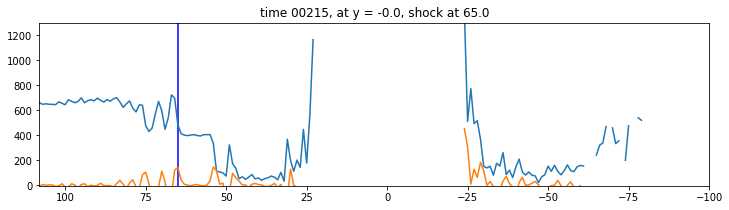

time = 00216
the chosen candidate for the position of the ip shock is -29.0
grad_v[ix_is] =  246.58473331184422
first try x_is = -29.0
This is absurd, the ip shock was located at 65.0 
                      and now it would be at -29.0!
[53. 54. 55. 56. 57. 58. 59. 60. 61. 62.]
the chosen candidate for the position of the ip shock is 54.0
grad_v[ix_is] =  179.88500927709129
Sounds like a good position for the ip shock


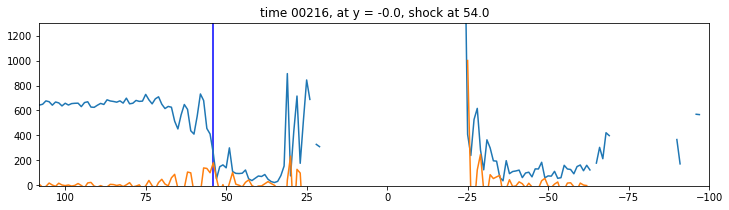

time = 00217
the chosen candidate for the position of the ip shock is -24.0
grad_v[ix_is] =  444.96628919260115
first try x_is = -24.0
This is absurd, the ip shock was located at 54.0 
                      and now it would be at -24.0!
[47. 48. 49. 50. 51.]
the chosen candidate for the position of the ip shock is 48.0
grad_v[ix_is] =  131.87077652375422
Sounds like a good position for the ip shock


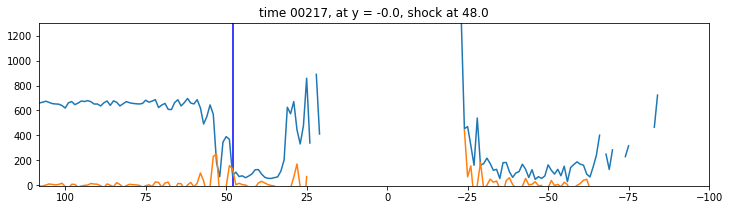

time = 00218
the chosen candidate for the position of the ip shock is -46.0
grad_v[ix_is] =  241.44841721010212
first try x_is = -46.0
This is absurd, the ip shock was located at 48.0 
                      and now it would be at -46.0!
[41. 42. 43. 44. 45.]
the chosen candidate for the position of the ip shock is 41.0
grad_v[ix_is] =  155.6315835929998
Sounds like a good position for the ip shock


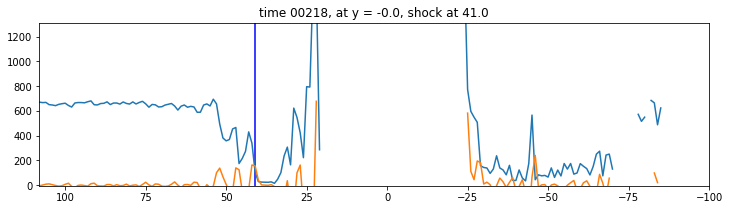

time = 00219
the chosen candidate for the position of the ip shock is -30.0
grad_v[ix_is] =  223.48252050243445
first try x_is = -30.0
This is absurd, the ip shock was located at 41.0 
                      and now it would be at -30.0!
[34. 35. 36. 37. 38.]
the chosen candidate for the position of the ip shock is 34.0
grad_v[ix_is] =  106.96203549739153
Sounds like a good position for the ip shock


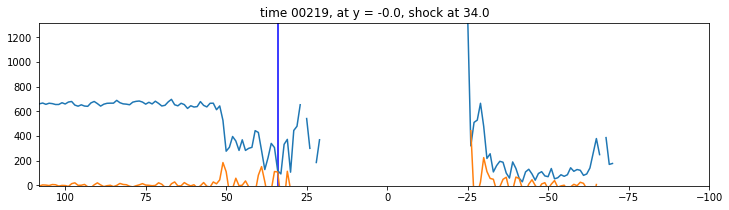

time = 00220
the chosen candidate for the position of the ip shock is -29.0
grad_v[ix_is] =  167.30108410824042
first try x_is = -29.0
This is absurd, the ip shock was located at 34.0 
                      and now it would be at -29.0!
[27. 28. 29. 30. 31.]
the chosen candidate for the position of the ip shock is 27.0
grad_v[ix_is] =  21.874870805124715
Sounds like a good position for the ip shock


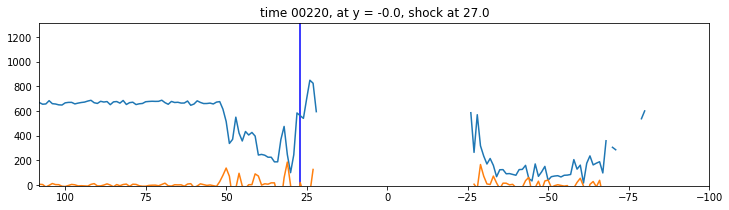

time = 00221
the chosen candidate for the position of the ip shock is -27.0
grad_v[ix_is] =  312.8762601689857
first try x_is = -27.0
This is absurd, the ip shock was located at 27.0 
                      and now it would be at -27.0!
[20. 21. 22. 23. 24.]
the chosen candidate for the position of the ip shock is 23.0
grad_v[ix_is] =  268.14327388602584
Sounds like a good position for the ip shock


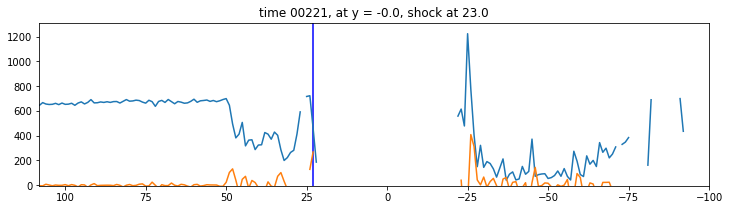

time = 00222
the chosen candidate for the position of the ip shock is -30.0
grad_v[ix_is] =  115.5347246653055
first try x_is = -30.0
This is absurd, the ip shock was located at 23.0 
                      and now it would be at -30.0!
[16. 17. 18. 19. 20.]
Sounds like a good position for the ip shock


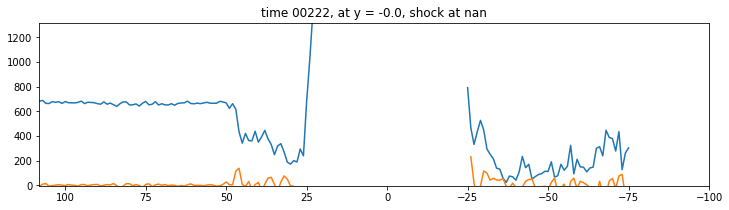

time = 00223
the chosen candidate for the position of the ip shock is -73.0
grad_v[ix_is] =  326.27571471581933
first try x_is = -73.0
Sounds like a good position for the ip shock


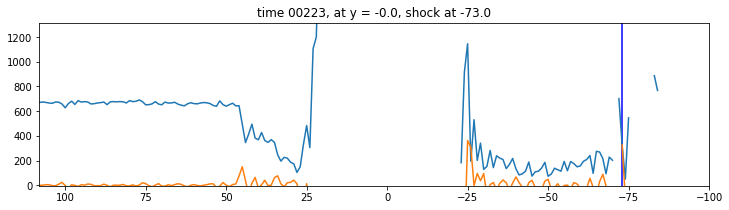

time = 00224
the chosen candidate for the position of the ip shock is -27.0
grad_v[ix_is] =  107.67088015906705
first try x_is = -27.0
This is absurd, the ip shock was located at -73.0 
                      and now it would be at -27.0!
[-80. -79. -78. -77. -76.]
the chosen candidate for the position of the ip shock is -77.0
grad_v[ix_is] =  78.99237403224956
Sounds like a good position for the ip shock


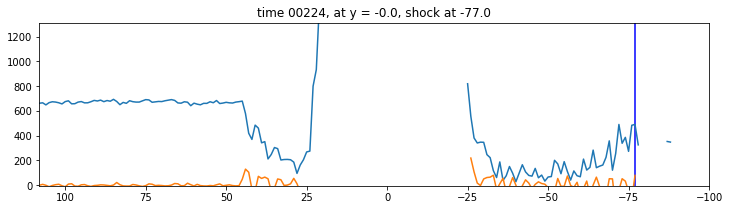

time = 00225
the chosen candidate for the position of the ip shock is -59.0
grad_v[ix_is] =  157.4886275310612
first try x_is = -59.0
This is absurd, the ip shock was located at -77.0 
                      and now it would be at -59.0!
[-84. -83. -82. -81. -80.]
Sounds like a good position for the ip shock


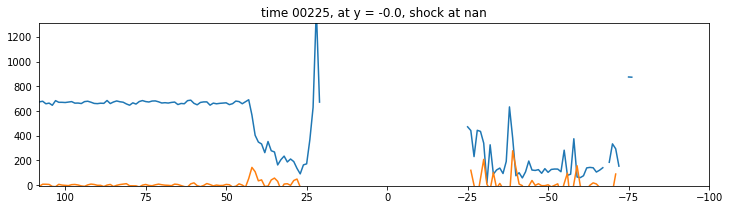

time = 00226
the chosen candidate for the position of the ip shock is -30.0
grad_v[ix_is] =  171.55044892514556
first try x_is = -30.0
Sounds like a good position for the ip shock


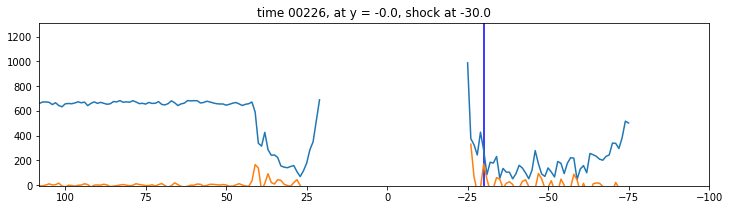

time = 00227
the chosen candidate for the position of the ip shock is -27.0
grad_v[ix_is] =  335.73783976584343
first try x_is = -27.0
This is absurd, the ip shock was located at -30.0 
                      and now it would be at -27.0!
[-37. -36. -35. -34. -33.]
the chosen candidate for the position of the ip shock is -35.0
grad_v[ix_is] =  108.82504388849785
Sounds like a good position for the ip shock


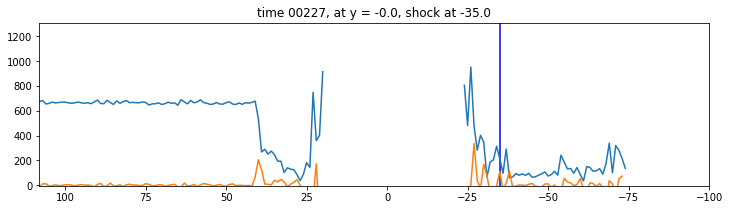

time = 00228
the chosen candidate for the position of the ip shock is -29.0
grad_v[ix_is] =  159.3115445673004
first try x_is = -29.0
This is absurd, the ip shock was located at -35.0 
                      and now it would be at -29.0!
[-42. -41. -40. -39. -38.]
the chosen candidate for the position of the ip shock is -39.0
grad_v[ix_is] =  75.31277158407241
Sounds like a good position for the ip shock


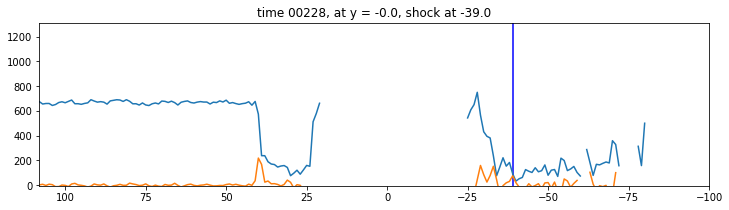

time = 00229
the chosen candidate for the position of the ip shock is -25.0
grad_v[ix_is] =  360.7432485076532
first try x_is = -25.0
This is absurd, the ip shock was located at -39.0 
                      and now it would be at -25.0!
[-46. -45. -44. -43. -42.]
Sounds like a good position for the ip shock


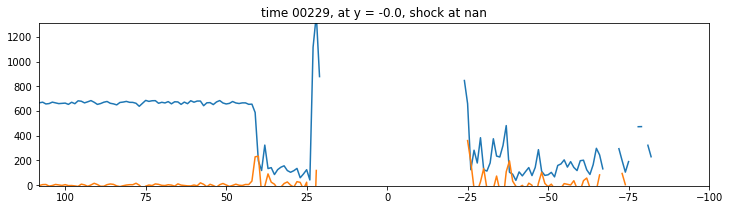

time = 00230
the chosen candidate for the position of the ip shock is -24.0
grad_v[ix_is] =  241.01492943306624
first try x_is = -24.0
Sounds like a good position for the ip shock


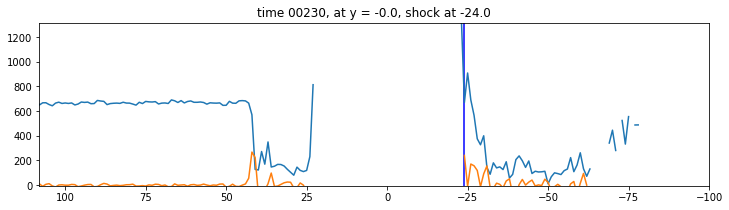

time = 00231
the chosen candidate for the position of the ip shock is -58.0
grad_v[ix_is] =  615.4631448046438
first try x_is = -58.0
This is absurd, the ip shock was located at -24.0 
                      and now it would be at -58.0!
[-31. -30. -29. -28. -27.]
the chosen candidate for the position of the ip shock is -31.0
grad_v[ix_is] =  307.87043501599146
Sounds like a good position for the ip shock


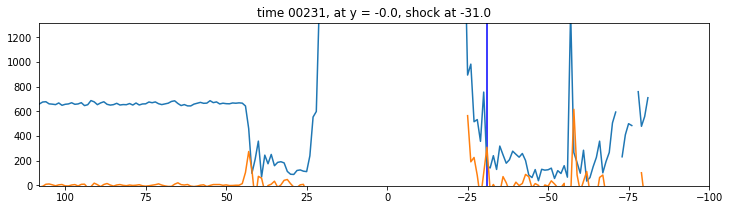

time = 00232
the chosen candidate for the position of the ip shock is -67.0
grad_v[ix_is] =  134.76488578222325
first try x_is = -67.0
This is absurd, the ip shock was located at -31.0 
                      and now it would be at -67.0!
[-38. -37. -36. -35. -34.]
the chosen candidate for the position of the ip shock is -38.0
grad_v[ix_is] =  21.42899321329189
Sounds like a good position for the ip shock


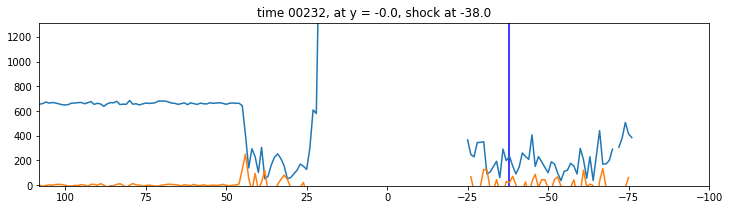

time = 00233
the chosen candidate for the position of the ip shock is -27.0
grad_v[ix_is] =  311.3482310975588
first try x_is = -27.0
This is absurd, the ip shock was located at -38.0 
                      and now it would be at -27.0!
[-45. -44. -43. -42. -41.]
the chosen candidate for the position of the ip shock is -43.0
grad_v[ix_is] =  55.55487147959589
Sounds like a good position for the ip shock


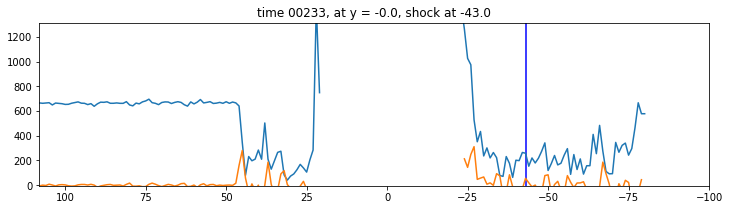

time = 00234
the chosen candidate for the position of the ip shock is -28.0
grad_v[ix_is] =  566.3377980599732
first try x_is = -28.0
This is absurd, the ip shock was located at -43.0 
                      and now it would be at -28.0!
[-50. -49. -48. -47. -46.]
Sounds like a good position for the ip shock


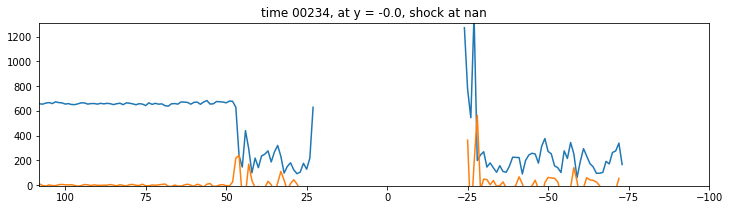

time = x
time = y
time = z


In [19]:
'''''''''''''''''''''''
Check the ip shock detection
'''''''''''''''''''''''

verbose = True
rcParams["figure.figsize"] = [12,3]

# dummy_time:
time = '00210'

list_data_y = stored_data[time]['Vx']['(xy) plane']
list_data_y = ['y = -0.0']

for str_y in list_data_y:

    t = []
    pos = []
                              
    for time in sorted(stored_data):
        
        if verbose:
            print(f'time = {time}')

        if not(time.isnumeric()):
            continue

        Vx_xy = stored_data[time]['Vx']['(xy) plane']
        Vy_xy = stored_data[time]['Vy']['(xy) plane']
        Vz_xy = stored_data[time]['Vz']['(xy) plane']

        if time=='00210':
            first_estimation = 115
        else:
            first_estimation = None
        if (str_y == 'y = -0.0') and (int(time) > 216):
            info = 'slow'
        else:
            info = None

        Vx = np.array(Vx_xy[str_y])
        Vy = np.array(Vy_xy[str_y])
        Vz = np.array(Vz_xy[str_y])

        V = (Vx, Vy, Vz)

        x_is =  simplified_find_ip_shock(V, verbose=verbose)
        t.extend([int(time)])
        pos.extend([x_is])

        if verbose:
            print(f'first try x_is = {x_is}')    

        absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose=verbose, info=info)
        j = 0
        while absurdity['absurd']:
            
#             v_slice = np.sqrt(Vx**2 + Vy**2 +Vz**2)
#             plt.axvline(x_is, color='blue')
#             plt.plot(x, v_slice)
#             plt.plot(x, np.gradient(v_slice))
#             plt.xlim([-100, 250])
#             plt.ylim([-5, 2*np.nanmean(v_slice)])
#             plt.title(f'time {time}, at {str_y}, shock at {x_is}: ABSURD')
#             plt.show()
                        
            test = absurdity['test']
            print(x[test])
            x_is =  simplified_find_ip_shock(V, test=test, verbose=verbose)
            pos[-1] = x_is
            
#             def debug():
#                 set_trace()
#                 absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose, info=info)
#                 return

#             if time=='00217':
#                 debug()

            absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose, info=info)
            j = j+1
            if j==6:
                pos[-1]=np.nan
#                 break

        if (pos[-1]==-100 or np.isnan(pos[-1])):
              pass
#             break

        v_slice = np.sqrt(Vx**2 + Vy**2 +Vz**2)

        plt.axvline(x_is, color='blue')
        plt.plot(x, v_slice)
        plt.plot(x, np.gradient(v_slice))
        plt.xlim([-100, 250])
        plt.ylim([-5, 2*np.nanmean(v_slice)])
        plt.title(f'time {time}, at {str_y}, shock at {x_is}')
        ax = plt.gca()
        ax.invert_xaxis()
        ax.set_xlim([108, -100])
        plt.show()

In [20]:
list_data_z = stored_data[time]['Vx']['(xz) plane']
list_data_z = ['z = 186.0']

for str_z in list_data_z:

    t = []
    pos = []
                              
    for time in sorted(stored_data):
        
        if verbose:
            print(f'time = {time}')

        if not(time.isnumeric()):
            continue

        Vx_xz = stored_data[time]['Vx']['(xz) plane']
        Vy_xz = stored_data[time]['Vy']['(xz) plane']
        Vz_xz = stored_data[time]['Vz']['(xz) plane']

        if time=='00210':
            first_estimation = 115
        else:
            first_estimation = None

        Vx = np.array(Vx_xz[str_z])
        Vy = np.array(Vy_xz[str_z])
        Vz = np.array(Vz_xz[str_z])

        V = (Vx, Vy, Vz)

        x_is =  simplified_find_ip_shock(V, verbose=verbose)
        t.extend([int(time)])
        pos.extend([x_is])

        if verbose:
            print(f'first try x_is = {x_is}')    

        absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose=verbose, info=info)
        j = 0
        while absurdity['absurd']:
            
#             v_slice = np.sqrt(Vx**2 + Vy**2 +Vz**2)
#             plt.axvline(x_is, color='blue')
#             plt.plot(x, v_slice)
#             plt.plot(x, np.gradient(v_slice))
#             plt.xlim([-100, 250])
#             plt.ylim([-5, 2*np.nanmean(v_slice)])
#             plt.title(f'time {time}, at {str_z}, shock at {x_is}: ABSURD')
#             plt.show()            
            
            test = absurdity['test']
            x_is =  simplified_find_ip_shock(V, test=test, verbose=verbose)
            pos[-1] = x_is
            absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose)
            j = j+1
            if j==6:
                pos[-1]=np.nan
                break

        if (pos[-1]==-100 or np.isnan(pos[-1])):
            break

        v_slice = np.sqrt(Vx**2 + Vy**2 +Vz**2)

        plt.axvline(x_is, color='blue')
        plt.plot(x, v_slice)
        plt.plot(x, np.gradient(v_slice))
        plt.xlim([-100, 250])
        plt.ylim([-5, 2*np.nanmean(v_slice)])
        plt.title(f'time {time}, at {str_z}, shock at {x_is}')
        ax = plt.gca()
        ax.invert_xaxis()
        plt.show()


TypeError: list indices must be integers or slices, not str

## Extract Velocity where I want it

In [ ]:
verbose = False

In [ ]:
stored_data['00220']['Vx']['(xy) plane'].keys()

In [ ]:
"""y slices"""

y_slice = 'y = 90.0'

print(y_slice)
    
t = []
pos = []

for time in sorted(stored_data):

    if verbose:
        print(f'time = {time}')

    if not(time.isnumeric()) or int(time)>=235:
        continue

    Vx_xy = stored_data[time]['Vx']['(xy) plane']
    Vy_xy = stored_data[time]['Vy']['(xy) plane']
    Vz_xy = stored_data[time]['Vz']['(xy) plane']

    if time=='00210':
        first_estimation = 115
    else:
        first_estimation = None
    if (y_slice == 'y = -0.0') and (int(time) > t_collision):
        info = 'slow'
    else:
        info = None

    Vx = Vx_xy[y_slice]
    Vy = Vy_xy[y_slice]
    Vz = Vz_xy[y_slice]

    V = (Vx, Vy, Vz)

    x_is =  simplified_find_ip_shock(V)
    t.extend([int(time)])
    pos.extend([x_is])

    if verbose:
        print(f'first try x_is = {x_is}')    

    absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose, info=info)
    j = 0
    while absurdity['absurd']:
        test = absurdity['test']
        x_is =  simplified_find_ip_shock(V, test=test, verbose=verbose)
        pos[-1] = x_is
        absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose, info=info)
        j = j+1
        if j==6:
            pos[-1]=np.nan
            break

    if (pos[-1]==-100 or np.isnan(pos[-1])):
        break

t = np.array(t)
pos = np.array(pos)

In [ ]:
stored_data['00220']['Vx']['(xz) plane'].keys()

In [ ]:
"""y slices"""

z_slice = 'z = 80.0'

print(z_slice)
    
t = []
pos = []

for time in sorted(stored_data):

    if verbose:
        print(f'time = {time}')

    if not(time.isnumeric()) or int(time)>=235:
        continue

    Vx_xz = stored_data[time]['Vx']['(xz) plane']
    Vy_xz = stored_data[time]['Vy']['(xz) plane']
    Vz_xz = stored_data[time]['Vz']['(xz) plane']

    if time=='00210':
        first_estimation = 115
    else:
        first_estimation = None

    Vx = Vx_xz[z_slice]
    Vy = Vy_xz[z_slice]
    Vz = Vz_xz[z_slice]

    V = (Vx, Vy, Vz)

    x_is =  simplified_find_ip_shock(V)
    t.extend([int(time)])
    pos.extend([x_is])

    if verbose:
        print(f'first try x_is = {x_is}')    

    absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose, info=info)
    j = 0
    while absurdity['absurd']:
        test = absurdity['test']
        x_is =  simplified_find_ip_shock(V, test=test, verbose=verbose)
        pos[-1] = x_is
        absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose, info=info)
        j = j+1
        if j==6:
            pos[-1]=np.nan
            break

    if (pos[-1]==-100 or np.isnan(pos[-1])):
        break

t = np.array(t)
pos = np.array(pos)

In [ ]:
#UGLY HARD CODE
#This information, and many others are in the .output files. 
#It would clean things up a lot to get them from there
#Module_diagnostics could do that. Then we could access them as MD.V_A, MD.cwp, etc
V_A = 89.371

In [ ]:
def v_shock(time):
    vshock = []
    for dt in [1,2,3]:
        t1 = time - dt
        t2 = time + dt
        v_shock = ( int(pos[t==t2]) - int(pos[t==t1]) ) / ( t2 - t1 )
        vshock.append([v_shock])
    return np.mean(vshock)*V_A


print(v_shock(230))